In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, precision_recall_fscore_support

/Users/varunchowdary/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/varunchowdary/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
!pip install category_encoders
import category_encoders as ce


In [3]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN


In [4]:
data = pd.read_csv('/Users/varunchowdary/Desktop/Credit_Card_Detection/Credit_Fraud_Detection/DataSets/fraud_test.csv')

In [54]:
data.head()

In [5]:
y = data["is_fraud"]
X = data.drop(['is_fraud'],axis=1)
     

#Modify columns
X_used = X.drop(['Unnamed: 0','street','city','state','cc_num', 'unix_time', 'trans_num'], axis=1)
X_used[['date', 'time']] = X_used['trans_date_trans_time'].str.split(' ', expand=True)
X_used[['day', 'month', 'year']] = X_used['date'].str.split('/', expand=True)
X_used['time'] = X_used['time'].apply(lambda x: x.split(':')[0])
X_used['dob'] = X_used['dob'].apply(lambda x: x.split('/')[-1])
X_used["gender"] = X_used["gender"].replace({'M': 0, 'F': 1})
X_used = X_used.drop(['trans_date_trans_time','date'], axis=1)

/var/folders/v5/dzlv9h1j1m35th_vy031s8d40000gn/T/ipykernel_11593/1512199050.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_used["gender"] = X_used["gender"].replace({'M': 0, 'F': 1})


Using code from Kaggle where the encode some of the variables with one hot encoding, delete unique identifer features, and also reformat some of the time data so that it is split up: https://www.kaggle.com/code/ivetrano/credit-card-fraud-prediction-99-7-accuracy

In [6]:
used_data = X_used.copy()
used_data['is_fraud'] = y

In [7]:
features = used_data.select_dtypes(np.object_).columns
cat_features = []
for feature in features:
    used_data[feature] = used_data[feature].astype('category')
    cat_features.append(feature)



In [8]:
X_train, X_test, y_train, y_test = train_test_split(used_data.drop('is_fraud', axis = 1),
                                                    used_data['is_fraud'],
                                                    stratify = used_data['is_fraud'],
                                                    test_size = 0.25)

train_data = X_train.copy()
train_data['is_fraud'] = y_train

In [9]:
cols_encoder = cat_features

encoder = ce.BinaryEncoder(cols=cols_encoder)

tra_encoder = encoder.fit_transform(X_train[cols_encoder])
test_encode = encoder.transform(X_test[cols_encoder])

X_train = X_train.drop(columns=cols_encoder).join(tra_encoder)

X_test = X_test.drop(columns=cols_encoder).join(test_encode)

In [10]:
rf_base_model = RandomForestClassifier()
rf_base_model.fit(X_train,y_train)

RandomForestClassifier()

In [12]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

ovs = RandomOverSampler(sampling_strategy = "auto", random_state = 11)
x_rovs, y_rovs = ovs.fit_resample(X_train, y_train)

rf_base_model.fit(x_rovs, y_rovs)
y_pred_proba_ovs = rf_base_model.predict_proba(X_test)
y_pred_ovs = rf_base_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_ovs[:,1])
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_ovs[:,1])
pr_auc = auc(recall, precision)
print(f"roc_auc: {roc_auc} pr_recall: {pr_auc}")

roc_auc: 0.9915387179238854 pr_recall: 0.8331881700304699


RandomForestClassifier()

In [13]:
precision_recall_fscore_support(y_test,y_pred_ovs)

(array([0.99785134, 0.9958159 ]),
 array([0.99999277, 0.44402985]),
 array([0.99892091, 0.61419355]),
 array([138394,    536]))

<function matplotlib.pyplot.show(close=None, block=None)>

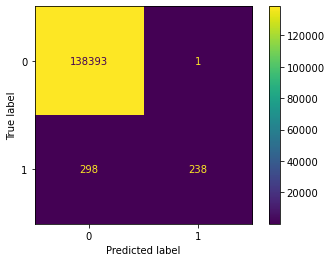

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
confusion_matrix(y_test,y_pred_ovs)

from sklearn.metrics import ConfusionMatrixDisplay,PrecisionRecallDisplay
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_ovs)
plt.show

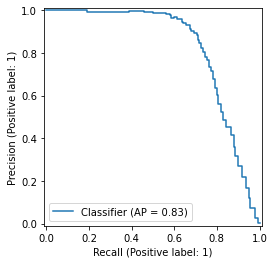

In [16]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba_ovs[:,1])